# Using Quantum Computers to Boost Whitebox Fuzzing

This demonstration shows how to harness the power of quantum computers for **enhancing software security**. Specifically, it uses the quantum Grover algorithm to boost the process of whitebox fuzzing.

According to [[1](#Whitebox)], the "killer-app" for whitebox fuzzing is the **testing of file and packet parsers**. As any vulnerability in such a parser might result in a costly security patch, it is worthwhile investing significant effort to protect the code.

## Fuzzing

<center><img src="https://docs.classiq.io/resources/fuzzing.jpeg" width=700/></center>

Fuzzing is a dynamic code testing technique that provides random data, known as "fuzz," to the inputs of a program. The goal is to find bugs, security loopholes, or other unexpected behavior in the software. By feeding the program various input combinations, a fuzzer aims to uncover weaknesses that might be exploited maliciously.

### Whitebox Fuzzing

Whitebox fuzzing, in particular, involves accessing the internal structure and code of the program. It combines static and dynamic analysis to not only execute the program with random inputs but also to achieve maximum code coverage, ensuring that all possible execution paths are tested. This allows for more targeted and efficient testing. It usually consists of a "symbolic execution" part: emulating the program to explore various branches and gathering them into a set of constraints.

The constraints are solved by a constraint solver, generating new fuzzing input to the program.

### Toy Example
This example emphasizes the importance of whitebox testing. First, trigger all code flows for this function:

In [46]:
def foo(x: int, y: int):
    if x == 12:
        if y > 3:
            return "a"
        return "b"
    if y + x < 9:
        if (x * y) % 4 == 1:
            return "c"
        return "d"
    return "e"

Now (due to simulation limitations) say that x, y are six-bit integers, so they are in the range [0, 63].
Try to get all the outputs of `foo` in a black-box way, e.g., by sampling random inputs:

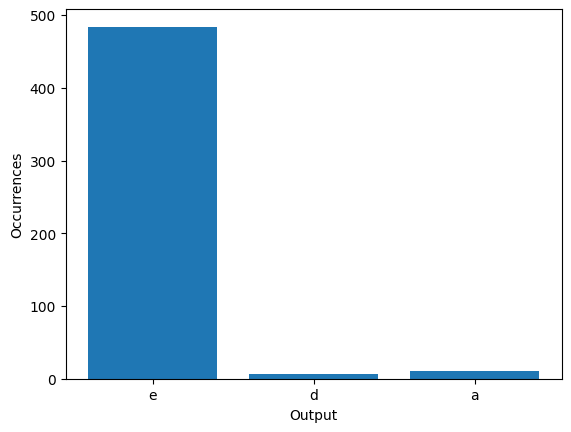

In [47]:
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt

np.random.seed(3)
x_samples = np.random.randint(0, 63, 500)
y_samples = np.random.randint(0, 63, 500)

outputs = [foo(x, y) for x, y in zip(x_samples, y_samples)]


def plot_outputs(outputs):
    char_counts = Counter(outputs)

    # Data for plotting
    chars = ["a", "b", "c", "d", "e"]
    counts = list(char_counts.values())

    # Plotting
    plt.bar(char_counts.keys(), char_counts.values())
    plt.xlabel("Output")
    plt.ylabel("Occurrences")
    plt.show()


plot_outputs(outputs)

Note that with 500 inputs, you only reach three of the five different outputs for `foo`.

However, by following the flow of `foo`, you can generate these constraints to the function:
- "a": $ (x = 12) \land (y \gt 3) $
- "b": $ (x = 12) \land (y \leq 3) $
- "c": $ (x + y \lt 9) \land (x \neq 12) \land (x \times y \mod 4 = 1)$
- "d": $ (x + y \lt 9) \land (x \neq 12) \land (x \times y \mod 4 \neq 1)$
- "e": $ (x \neq 12) \land (x + y \lt 9)$

Now, to trigger each of the different outputs, find inputs that satisfy the constraints. Some constraints might not be satisfiable for any input. Although this toy example is easy, the general case, which is an instance of the Constraints Satisfaction Problem (CSP), is computationally hard and belongs to the $\text{NP-Complete}$ complexity class.

## Here Comes the Quantum Part!

### Grover's Algorithm
The physical nature of a quantum computer can be harnessed to generate inputs to the function. Specifically, you can create a 'superposition' of all different inputs: a physical state that holds all the possible assignments to the function inputs, for which to compute whether the constraints are fulfilled. The quantum computer allows only a single classical output of the variable. This is where Grover's algorithm [[1](#Gro97),[2](#GroWiki)] is useful: it can generate "good" samples with a high probability, achieving a quadratic(!) speedup over a classical brute force approach.

### Oracle Function
In the heart of the algorithm, implement an oracle that computes for each state:

$
O |x\rangle =
\begin{cases}
-|x\rangle & \text{if } f(x) = 1 \\
|x\rangle & \text{otherwise}
\end{cases}
$

Classiq has a built-in arithmetic engine for computing such oracles. Specifically, take the hardest constraint:

* **"c": $ (x + y < 9) \land (x \neq 12) \land (x \times y \mod 4 = 1)$**

Eliminate the $x \neq 12$ as it is already satisfied given the first clause, and create a predicate function for it:

In [48]:
from classiq import *
from classiq.qmod.symbolic import logical_and


@qperm
def my_predicate(x: Const[QNum], y: Const[QNum], res: QBit) -> None:
    res ^= logical_and((x + y < 9), ((x * y) % 4 == 1))

Create a phase oracle:

In [49]:
@qfunc
def prep_minus(out: QBit) -> None:
    X(out)
    H(out)


@qfunc
def my_oracle(predicate: QCallable[QBit]) -> None:
    aux = QBit()
    allocate(aux)
    within_apply(within=lambda: prep_minus(aux), apply=lambda: predicate(aux))
    free(aux)

See how a quantum oracle looks:

In [50]:
REGISTER_SIZE = 6


@qfunc
def main(x: Output[QNum], y: Output[QNum]):
    allocate(REGISTER_SIZE, x)
    allocate(REGISTER_SIZE, y)
    my_oracle(predicate=lambda q: my_predicate(x, y, q))


MAX_WIDTH_ORACLE = 25
qmod_oracle = create_model(main)
qmod_oracle = set_constraints(qmod_oracle, max_width=MAX_WIDTH_ORACLE)
qprog_oracle = synthesize(qmod_oracle)
show(qprog_oracle)

Quantum program link: https://platform.classiq.io/circuit/38Ds32bIYkFi7ykX2FGa0XKMP73


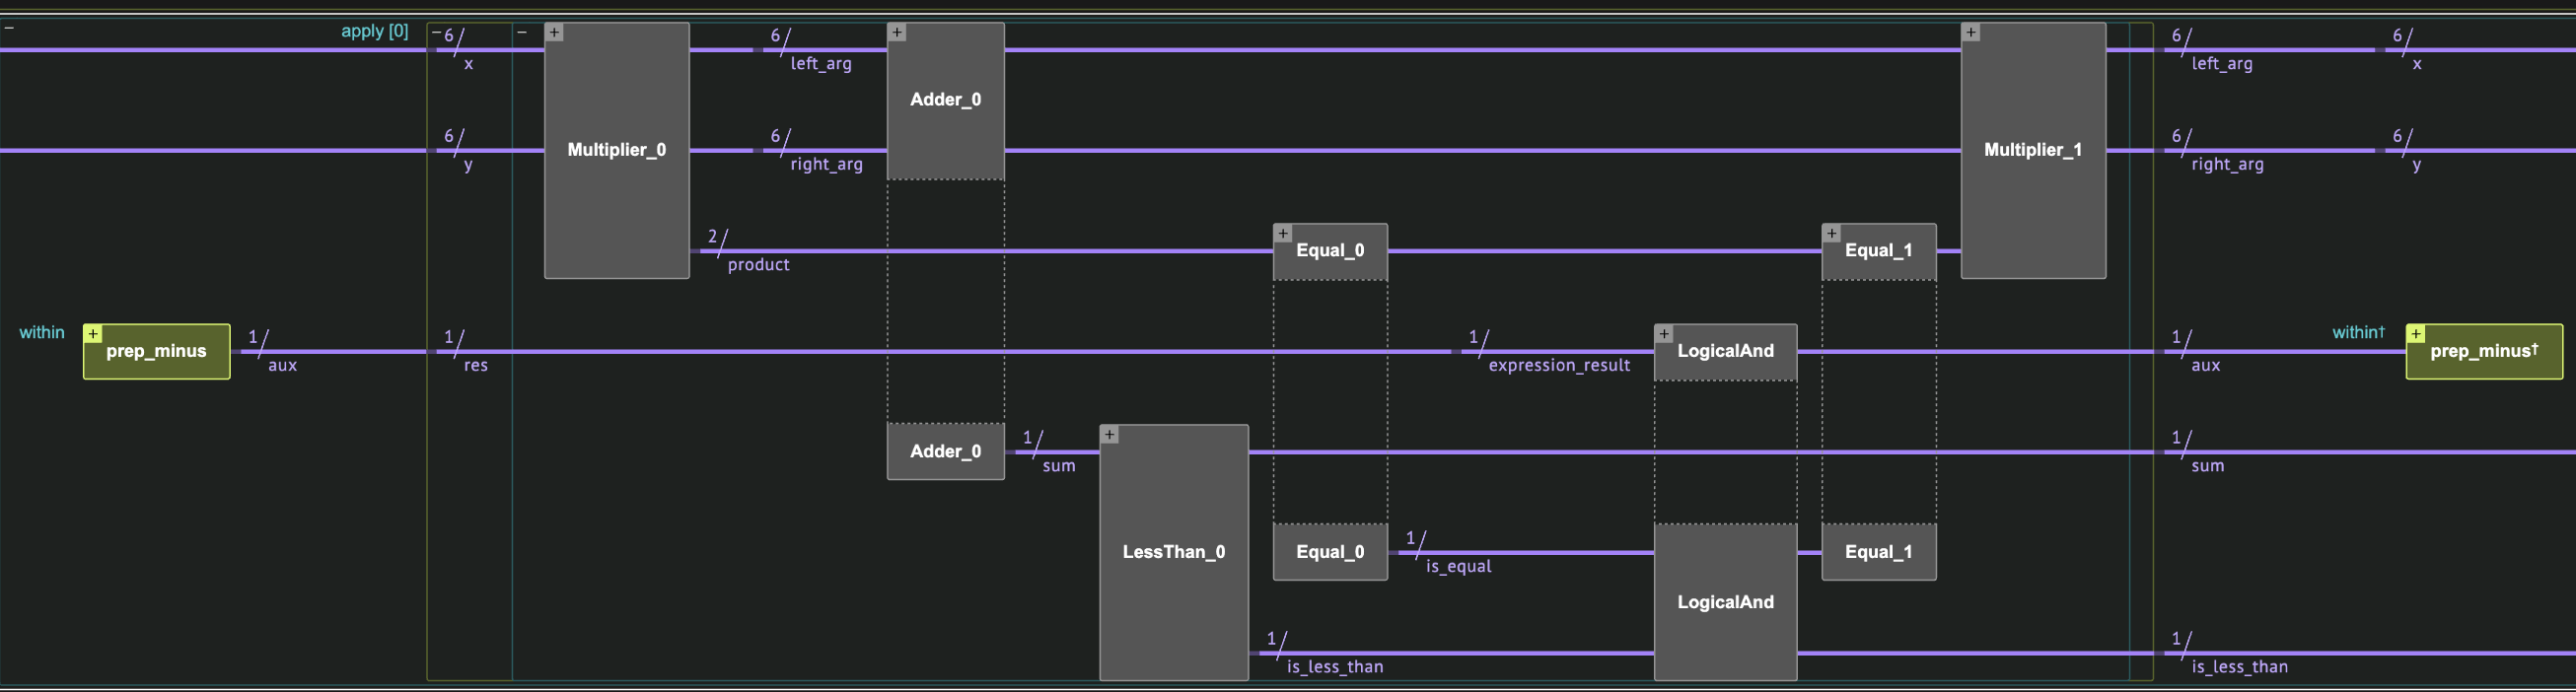

### Full Grover's Circuit

Now create the full circuit implementation of Grover's algorithm.

#### State Preparation

Load the uniform superposition state over all possible input assignments to `foo` using the `hadamard_transform`:

In [51]:
@qfunc
def my_sp(x: QNum, y: QNum):
    hadamard_transform(x)
    hadamard_transform(y)

#### Grover Operator

In [52]:
@qperm
def zero_predicate(x: Const[QNum], y: Const[QNum], res: QBit):
    temp = QNum()
    within_apply(lambda: bind([x, y], temp), lambda: inplace_xor(temp == 0, res))


@qfunc
def my_diffuser(sp_operand: QCallable[QNum, QNum], x: QNum, y: QNum):

    within_apply(
        lambda: invert(lambda: sp_operand(x, y)),
        lambda: my_oracle(predicate=lambda q: zero_predicate(x, y, q)),
    )


@qfunc
def my_grover_operator(oracle_operand: QCallable, diffuser_operand: QCallable):
    oracle_operand()
    diffuser_operand()

#### Grover Repetitions

The algorithm includes applying a quantum oracle in repetition, such that the probability to sample a good state "rotates" from low to high. Without knowing the concentration of solutions beforehand (which is the common case), one might overshoot with too many repetitions and not arrive at a solution. Fixed Point Amplitude Amplification (FFPA) ([4](#FFPA)), for example, is a modification to the basic Grover algorithm, which does not suffer from the overshoot issue. However, here, for simplicity, use the basic Grover's algorithm. Assume that this specific state is only satisfied for a specific input, and calculate the number of oracle repetitions required:

In [53]:
GROVER_REPEATS = np.pi / 4 * np.sqrt(2 ** (2 * REGISTER_SIZE) / 2)
GROVER_REPEATS = np.round(GROVER_REPEATS)
print(GROVER_REPEATS)

36.0


This is indeed ~ the square root of the number of possible assignments: $2^{12}$ in this case!

To save simulation time, simplify even further: use only several Grover repetitions to show that this raises the probability of sampling a "c" input:

In [54]:
@qfunc
def main(x: Output[QNum], y: Output[QNum]):
    allocate(REGISTER_SIZE, x)
    allocate(REGISTER_SIZE, y)
    my_sp(x, y)
    power(
        20,
        lambda: my_grover_operator(
            lambda: my_oracle(predicate=lambda q: my_predicate(x, y, q)),
            lambda: my_diffuser(lambda x, y: my_sp(x, y), x, y),
        ),
    )


qmod_grover = create_model(main)

Set constraints for the resulting circuit so you can simulate it on a quantum simulator:

In [55]:
MAX_WIDTH_GROVER = 25
qmod_grover = set_constraints(qmod_grover, max_width=MAX_WIDTH_GROVER)

### Synthesizing the Model

Synthesize the circuit using the Classiq synthesis engine. The synthesis takes the high level model definition and creates a quantum circuit implementation within a few seconds:

In [56]:
qprog_grover = synthesize(qmod_grover)

### Showing the Resulting Circuit

When the Classiq synthesis engine finishes the job, display the resulting circuit in the interactive GUI:

In [57]:
show(qprog_grover)

Quantum program link: https://platform.classiq.io/circuit/38DsRiUd8BrPZVhiGhVo0pvShEt


### Executing the Circuit

Lastly, execute the resulting circuit in the Classiq interface using the `execute` function:

In [58]:
qprog_grover = set_quantum_program_execution_preferences(
    qprog_grover, ExecutionPreferences(num_shots=500)
)

result = execute(qprog_grover).result_value()

These are the counts of the sampled bit strings, from the 500 samples drawn from the circuit. Some of the bit strings are sampled with a much higher probability. Extract `x` and `y` values from the sampling results to determine if you have inputs for "c":

In [61]:
samples = []
for x, y, shot in [
    [sample.state["x"], sample.state["y"], sample.shots]
    for sample in result.parsed_counts
]:
    foo_out = foo(x, y)
    samples = samples + [foo_out] * shot
    if foo_out == "c":
        print(f"'c' satisfying sample: {x=}, {y=}, probability={shot/500:.2f}")

'c' satisfying sample: x=3, y=3, probability=0.25
'c' satisfying sample: x=1, y=1, probability=0.24
'c' satisfying sample: x=5, y=1, probability=0.22
'c' satisfying sample: x=1, y=5, probability=0.21


This corresponds exactly to the four peaks in the results:

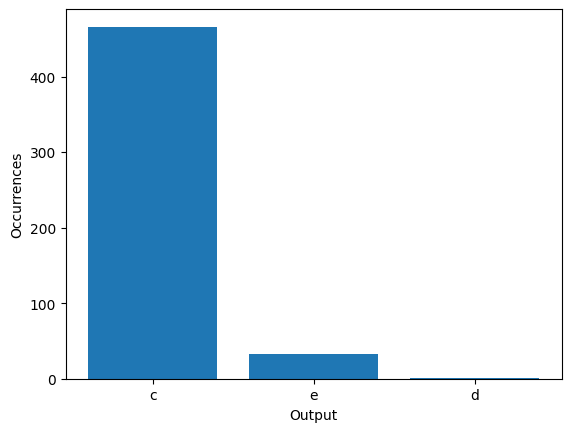

In [62]:
plot_outputs(samples)

And "c" is indeed sampled with a higher probability! If you do 36 Grover repetitions, you would expect to get c with a probability of ~1.

## Notes
- While "black-box" fuzzing can also potentially benefit from quantum computers, a large quantity of quantum resources is generally required to emulate the state of the classical program. On the other hand, the "white-box" case is lower hanging fruit, requiring fewer resources for a hybrid quantum-classical approach.
- This example shows quadratic improvement in comparison to a classical "brute force" solver. However, in reality, there are much faster classical solvers. As a basic example, a solver can "prune" branches of a search by backtracking if a partial assignment is not satisfiable. Such modifications are, in general, also feasible on a quantum computer. For example, see [[5](#Backtrack)] on Quantum Backtracking.

# References

<a name='Whitebox'>[1]</a> [Bounimova, E., Godefroid, P., and Molnar, D. (2013). Billions and billions of constraints: Whitebox fuzz testing in production, 35th International Conference on Software Engineering (ICSE), San Francisco, CA, USA, 2013, pp. 122-131, doi: 10.1109/ICSE.2013.6606558](https://ieeexplore.ieee.org/document/6606558)

<a name='Gro97'>[2]</a> [Grover, Lov K. (1997). Quantum mechanics helps in searching for a needle in a haystack. Physical Review Letters, 79.2: 325.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.79.325)

<a name='GroWiki'>[3]</a> [Grover's algorithm (Wikipedia)](https://en.wikipedia.org/wiki/Grover%27s_algorithm).

<a name='FPAA'>[4]</a> [Yoder, Theodore J. et al. (2014). Fixed-point quantum search with an optimal number of queries. Physical Review Letters, 113 21: 210501](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.210501)

<a name='Backtrack'>[5]</a> [Montanaro, Ashley. (2015). Quantum walk speedup of backtracking algorithms. Theory of Computing. 14. 10.4086/toc.2018.v014a015](https://theoryofcomputing.org/articles/v014a015/)
